In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
class JetImageGenerator(object):
    def __init__(self,batch_size=32):
        # structure of dataframe
        self.jet_columns = ['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight',
                            'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7',
                            'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7',
                            'jet_ncand_ak7','ak7pfcand_ijet']
        self.NDIM = self.jet_columns.index('jet_isW_ak7')

        self.cand_columns = ['event', 'jet_pt_ak7', 'jet_isW_ak7','jet_jes_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta',
                             'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet']

        self.batch_size = batch_size

        self.categories = ['TT','QCD']
        self.file_pattern = {
            'TT': 'output_TT/*.npy',
            'QCD': 'output_QCD*/*.npy'
        }
        
        self.preselection = {
            'TT': lambda df: df[(df.jet_pt_ak7 > 200) & (df.jet_pt_ak7 < 500) &  (df.jet_isW_ak7==1)],
            'QCD': lambda df: df[(df.jet_pt_ak7 > 200) & (df.jet_pt_ak7 < 500) &  (df.jet_isW_ak7==0)],
        }
                
        # list of files
        self.inputs = {}
        for cat in self.categories:
            self.inputs[cat] = glob.glob(self.file_pattern[cat])
        
        
        
    def _load_category(self,category,i):
        if i<len(self.inputs[category]):
            try:
                fname = self.inputs[category][i]
                #print category, i, fname
                params = np.load(fname)
                jet_df = pd.DataFrame(params,columns=self.jet_columns)
                cand_df = pd.DataFrame(params,columns=self.cand_columns)
                jet_df.drop_duplicates(inplace=True)
                jet_df = self.preselection[category](jet_df)
                cand_df = self.preselection[category](cand_df)
                return jet_df, cand_df
            except:
                print 'bad file: %s'%fname
                if fname in self.inputs[category]: self.inputs[category].remove(fname)
        return pd.DataFrame(), pd.DataFrame()
    
    def generator(self,test=False,crossvalidation=False):

        percat = self.batch_size/len(self.categories)

        icat = {cat:0 for cat in self.categories}
        cat_X = {cat:np.array([]) for cat in self.categories}
        cat_y = {cat:np.array([]) for cat in self.categories}
        
        kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
        
        while True:
            # stop iteration
            #for cat in self.categories:
            #    if len(cat_y[cat])<percat and icat[cat]>=len(self.inputs[cat]):
            #        raise StopIteration
            
            # load data
            for cat in self.categories:
                while len(cat_y[cat])<percat:
                    # load from file
                    jet_df, cand_df = self._load_category(cat,icat[cat]%len(self.inputs[cat])) # allow infinite looping
                    # get the image from pf cands
                    if K.image_dim_ordering()=='tf':
                        jet_images = np.zeros((len(jet_df), nx, ny, 1))
                    else:        
                        jet_images = np.zeros((len(jet_df), 1, nx, ny))
                    njets = 0
                    for i in range(0,len(jet_df)):
                        njets+=1
                        # get the ith jet
                        df_cand_i = cand_df[(cand_df['ak7pfcand_ijet'] == jet_df['ak7pfcand_ijet'].iloc[i]) & (cand_df['event'] == jet_df['event'].iloc[i])]
                        # relative eta
                        x = df_cand_i['ak7pfcand_eta']-df_cand_i['ak7pfcand_eta'].iloc[0]
                        # relative phi
                        y = df_cand_i['ak7pfcand_phi']-df_cand_i['ak7pfcand_phi'].iloc[0]
                        weights = df_cand_i['ak7pfcand_pt'] # pt of candidate is the weight
                        x,y = rotate_and_reflect(x,y,weights)
                        hist, xedges, yedges = np.histogram2d(x, y,weights=weights, bins=(xbins,ybins))
                        for ix in range(0,nx):
                            for iy in range(0,ny):
                                if K.image_dim_ordering()=='tf':
                                    jet_images[i,ix,iy,0] = hist[ix,iy]
                                else:
                                    jet_images[i,0,ix,iy] = hist[ix,iy]
                    # split them to test and train
                    X = jet_images
                    #print X.shape
                    y = jet_df['jet_jes_ak7']
                    #print y.shape
                    #encoder = LabelEncoder()
                    #encoder.fit(y)
                    #encoded_y = encoder.transform(y)
                    #data_train, data_test = list(kfold.split(X, y))[int(crossvalidation)]
                    mixed = list(zip(X,y))
                    np.random.shuffle(mixed) 
                    data_train = mixed[:int(len(mixed)*0.4)]
                    data_test = mixed[int(len(mixed)*0.4):]                    
                    # select test or train
                    sample = data_test if test else data_train
                    X = np.array([C[0] for C in sample])
                    y = np.array([C[1] for C in sample])
                    #print X
                    #print y
                    cat_X[cat] = np.vstack((cat_X[cat],X)) if cat_X[cat].size else X
                    cat_y[cat] = np.hstack((cat_y[cat],y)) if cat_y[cat].size else y
                    icat[cat] += 1

            # build combined sample based on batch_size
            all_X = np.array([])
            all_y = np.array([])
            for cat in self.categories:
                X = cat_X[cat][:percat]
                y = cat_y[cat][:percat]
                cat_X[cat] = cat_X[cat][percat:]
                cat_y[cat] = cat_y[cat][percat:]
                all_X = np.vstack((all_X,X)) if all_X.size else X
                all_y = np.hstack((all_y,y)) if all_y.size else y

            yield all_X, all_y

In [3]:
# get input numpy arrays
inputs = {}
inputs['TT'] = glob.glob('output_TT/*job*.npy')
inputs['QCD120'] = glob.glob('output_QCD120/*job*.npy')
inputs['QCD170'] = glob.glob('output_QCD170/*job*.npy')
inputs['QCD300'] = glob.glob('output_QCD300/*job*.npy')
inputs['QCD470'] = glob.glob('output_QCD470/*job*.npy')

list_params = {}
params = {}
for key, input_files in inputs.iteritems():
    list_params[key] = []
    for in_file in input_files:
        try:
            arr = np.load(in_file)
            list_params[key].append(arr)
        except ValueError:
            print 'bad file: %s'%in_file
    params[key] = np.concatenate(list_params[key])
    print len(params)

1
2
3
4
5


In [4]:
# convert to pandas dataframe
df_dict = {}
print params['TT'].dtype.names
df_dict['TT'] = pd.DataFrame(params['TT'],columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7', 'jet_jes_ak7', 'pthat','mcweight'])
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin] = pd.DataFrame(params[QCDbin],columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7', 'jet_jes_ak7', 'pthat','mcweight'])

df_dict['TT'] = df_dict['TT'].drop_duplicates()
df_dict['TT'] =  df_dict['TT'][(df_dict['TT'].jet_pt_ak7 > 200) & (df_dict['TT'].jet_pt_ak7 < 500) &  (df_dict['TT'].jet_isW_ak7==1)]

print 'number of W jets: %i'%len(df_dict['TT'])

for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin] = df_dict[QCDbin].drop_duplicates()
    df_dict[QCDbin] =  df_dict[QCDbin][(df_dict[QCDbin].jet_pt_ak7 > 200) & (df_dict[QCDbin].jet_pt_ak7 < 500) & (df_dict[QCDbin].jet_isW_ak7==0)]
    # take every 20th jet just to make the training faster and have a sample roughly the size of W jets
    #df_dict[QCDbin] = df_dict[QCDbin].iloc[::20, :]
    
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    print 'number of QCD jets in bin %s: %i'%( QCDbin, len(df_dict[QCDbin]))

    
df_dict['QCD'] = pd.concat([df_dict['QCD120'],df_dict['QCD170'],df_dict['QCD300'],df_dict['QCD470']])
df = pd.concat([df_dict['TT'],df_dict['QCD']])

print df_dict['TT'].iloc[:3]
print df_dict['QCD'].iloc[:3]

('run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_ptraw_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_Eraw_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7', 'genjet_pt_ak7', 'genjet_eta_ak7', 'genjet_phi_ak7', 'genjet_E_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet')
number of W jets: 502
number of QCD jets in bin QCD120: 724
number of QCD jets in bin QCD170: 13794
number of QCD jets in bin QCD300: 32970
number of QCD jets in bin QCD470: 18572
       jet_pt_ak7  jet_tau21_ak7  jet_msd_ak7  jet_ncand_ak7  jet_isW_ak7  \
2511   317.490460       0.109360    77.987768             32            1   
12360  287.095779       0.394389    91.601222             77            1   
31113  257.045551       0.422063    79.535011             79            1   

       jet_jes_ak7  pthat    mcweight  
2511      1.032562    0.0  147.3

In [5]:
# now let's prepare some jet images
print params['TT'].dtype.names

df_dict_jet = {}
df_dict_jet['TT'] = pd.DataFrame(params['TT'],columns=['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7',  'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','jet_jes_ak7','ak7pfcand_ijet'])
df_dict_jet['TT'] = df_dict_jet['TT'].drop_duplicates()
df_dict_jet['TT'] =  df_dict_jet['TT'][(df_dict_jet['TT'].jet_pt_ak7 > 200) & (df_dict_jet['TT'].jet_pt_ak7 < 500) &  (df_dict_jet['TT'].jet_isW_ak7==1)]

df_dict_cand = {}
df_dict_cand['TT'] = pd.DataFrame(params['TT'],columns=['event', 'jet_pt_ak7', 'jet_isW_ak7','jet_jes_ak7',  'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet'])
df_dict_cand['TT'] =  df_dict_cand['TT'][(df_dict_cand['TT'].jet_pt_ak7 > 200) & (df_dict_cand['TT'].jet_pt_ak7 < 500) &  (df_dict_cand['TT'].jet_isW_ak7==1)]


for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict_jet[QCDbin] = pd.DataFrame(params[QCDbin],columns=['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7',  'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7','jet_jes_ak7','ak7pfcand_ijet'])
    df_dict_jet[QCDbin] = df_dict_jet[QCDbin].drop_duplicates()
    df_dict_jet[QCDbin] =  df_dict_jet[QCDbin][(df_dict_jet[QCDbin].jet_pt_ak7 > 200) & (df_dict_jet[QCDbin].jet_pt_ak7 < 500) &  (df_dict_jet[QCDbin].jet_isW_ak7==0)]
    # take every 20th jet just to make the training faster and have a sample roughly the size of W jets
    #df_dict_jet[QCDbin] = df_dict_jet[QCDbin].iloc[::20, :]
    
    df_dict_cand[QCDbin] = pd.DataFrame(params[QCDbin],columns=['event', 'jet_pt_ak7',  'jet_isW_ak7','jet_jes_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet'])
    df_dict_cand[QCDbin] =  df_dict_cand[QCDbin][(df_dict_cand[QCDbin].jet_pt_ak7 > 200) & (df_dict_cand[QCDbin].jet_pt_ak7 < 500) &  (df_dict_cand[QCDbin].jet_isW_ak7==0)]
    
df_dict_jet['QCD'] = pd.concat([df_dict_jet['QCD120'],df_dict_jet['QCD170'],df_dict_jet['QCD300'],df_dict_jet['QCD470']])
df_dict_cand['QCD'] = pd.concat([df_dict_cand['QCD120'],df_dict_cand['QCD170'],df_dict_cand['QCD300'],df_dict_cand['QCD470']])

print len(df_dict_jet['QCD'])


('run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_ptraw_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_Eraw_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7', 'genjet_pt_ak7', 'genjet_eta_ak7', 'genjet_phi_ak7', 'genjet_E_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet')
66060


In [6]:
# rotation + (possible) reflection needed later
def rotate_and_reflect(x,y,w):
    rot_x = []
    rot_y = []
    theta = 0
    maxPt = -1
    for ix, iy, iw in zip(x, y, w):
        dv = np.matrix([[ix],[iy]])-np.matrix([[x.iloc[0]],[y.iloc[0]]])
        dR = np.linalg.norm(dv)
        thisPt = iw
        if dR > 0.35 and thisPt > maxPt:
            maxPt = thisPt
            # rotation in eta-phi plane c.f  https://arxiv.org/abs/1407.5675 and https://arxiv.org/abs/1511.05190:
            # theta = -np.arctan2(iy,ix)-np.radians(90)
            # rotation by lorentz transformation c.f. https://arxiv.org/abs/1704.02124:
            px = iw * np.cos(iy)
            py = iw * np.sin(iy)
            pz = iw * np.sinh(ix)
            theta = np.arctan2(py,pz)+np.radians(90)
            
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    for ix, iy, iw in zip(x, y, w):
        # rotation in eta-phi plane:
        #rot = R*np.matrix([[ix],[iy]])
        #rix, riy = rot[0,0], rot[1,0]
        # rotation by lorentz transformation
        px = iw * np.cos(iy)
        py = iw * np.sin(iy)
        pz = iw * np.sinh(ix)
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        rot_x.append(rix)
        rot_y.append(riy)
        
    # now reflect if leftSum > rightSum
    leftSum = 0
    rightSum = 0
    for ix, iy, iw in zip(x, y, w):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
    if leftSum > rightSum:
        ref_x = [-1.*rix for rix in rot_x]
        ref_y = rot_y
    else:
        ref_x = rot_x
        ref_y = rot_y
    
    return np.array(ref_x), np.array(ref_y)

from keras import backend as K
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [7]:
import matplotlib as mpl

nx = 30 # size of image in eta
ny = 30 # size of image in phi
xbins = np.linspace(-1.4,1.4,nx+1)
ybins = np.linspace(-1.4,1.4,ny+1)
jet_images = {}
# 4D tensor
# 1st dim is jet index
# 2nd dim is pt value (or rgb, etc.)
# 3rd dim is eta bin
# 4th dim is phi bin

In [8]:
def plotJet(process='TT',njets_to_plot=-1):
    list_x = []
    list_y = []
    list_w = []
    njets = 0

    if K.image_dim_ordering()=='tf':
        jet_images[process] = np.zeros((len(df_dict_jet[process]), nx, ny, 1))
    else:        
        jet_images[process] = np.zeros((len(df_dict_jet[process]), 1, nx, ny))
    
    njets_ = []
    if njets_to_plot == -1:
        njets_ = range(0,len(df_dict_jet[process]))
    else:
        njets_ = range(0,njets_to_plot)
    
    for i in njets_:
        njets+=1
        # get the ith jet
        df_dict_cand_i = {}
        df_dict_cand_i[process] = df_dict_cand[process][(df_dict_cand[process]['ak7pfcand_ijet'] == df_dict_jet[process]['ak7pfcand_ijet'].iloc[i]) & (df_dict_cand[process]['event'] == df_dict_jet[process]['event'].iloc[i]) ]
        # relative eta
        x = df_dict_cand_i[process]['ak7pfcand_eta']-df_dict_cand_i[process]['ak7pfcand_eta'].iloc[0]
        # relative phi
        y = df_dict_cand_i[process]['ak7pfcand_phi']-df_dict_cand_i[process]['ak7pfcand_phi'].iloc[0]
        weights = df_dict_cand_i[process]['ak7pfcand_pt'] # pt of candidate is the weight
        x,y = rotate_and_reflect(x,y,weights)
        list_x.append(x)
        list_y.append(y)
        list_w.append(weights)
        hist, xedges, yedges = np.histogram2d(x, y,weights=weights, bins=(xbins,ybins))
        for ix in range(0,nx):
            for iy in range(0,ny):
                if K.image_dim_ordering()=='tf':
                    jet_images[process][i,ix,iy,0] = hist[ix,iy]
                else:
                    jet_images[process][i,0,ix,iy] = hist[ix,iy]
    all_x = np.concatenate(list_x)
    all_y = np.concatenate(list_y)
    all_w = np.concatenate(list_w)
    all_w = 1.*all_w/njets # to get average
    plt.figure('W') 
    plt.hist2d(all_x, all_y, weights=all_w, bins=(xbins,ybins), norm=mpl.colors.LogNorm())
    plt.colorbar()
    plt.xlabel('eta')
    plt.ylabel('phi')
    plt.show()

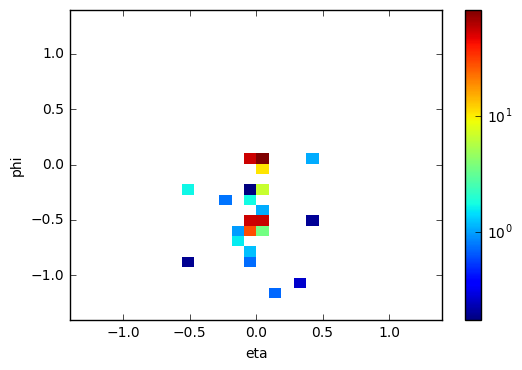

In [9]:
plotJet(process='TT',njets_to_plot=1)

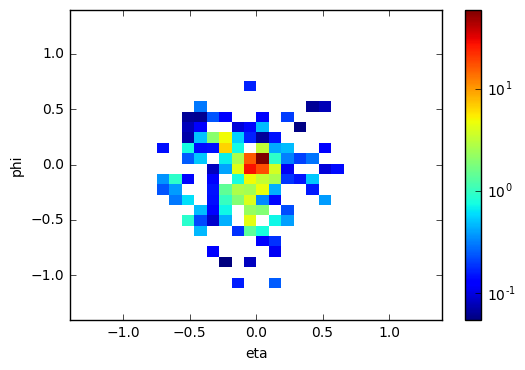

In [10]:
plotJet('QCD',5)

In [11]:
# Model
def build_conv_model():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    if K.image_dim_ordering()=='tf':
        input_layer = Input(shape=(nx, ny, 1))
    else:
        input_layer = Input(shape=(1, nx, ny))
    layer = Convolution2D(8, 11, 11, border_mode='same')(input_layer)
    # the original layers were 8, 11, 11. reduced it to increase feature recognition 
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    layer = Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.20)(layer)
    layer = Dense(20)(layer)
    layer = Dropout(0.10)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    model = Model(input=input_layer, output=output_layer)
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model
conv_model = build_conv_model()
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 30, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 30, 8)     976         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 30, 30, 8)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 15, 15, 8)     0           activation_1[0][0]               
___________________________________________________________________________________________

In [ ]:
#jetImageGenerator = JetImageGenerator()
#X,Y = jetImageGenerator.generator().next()
#print X.shape
#print Y.shape

In [12]:
# Run classifier with cross-validation and plot ROC curves
kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
models = []
for cv, color in zip(range(0,2), colors):
    conv_model = build_conv_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    jetImageGenerator = JetImageGenerator()
    history = conv_model.fit_generator(jetImageGenerator.generator(crossvalidation=int(cv)), 64, validation_data=jetImageGenerator.generator(test=True), nb_val_samples=64, nb_epoch=10, verbose=1, callbacks=[early_stopping])
    histories.append(history)
    models.append(conv_model)

Epoch 1/10


/home/ec2-user/src/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in arcsin
/home/ec2-user/src/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


64/64 [==============================] - 244s - loss: 0.2500 - acc: 0.0000e+00 - val_loss: 0.2177 - val_acc: 0.0000e+00
Epoch 2/10
64/64 [==============================] - 2s - loss: 0.2121 - acc: 0.0000e+00 - val_loss: 0.1865 - val_acc: 0.0000e+00
Epoch 3/10
64/64 [==============================] - 2s - loss: 0.1820 - acc: 0.0000e+00 - val_loss: 0.1726 - val_acc: 0.0000e+00
Epoch 4/10
64/64 [==============================] - 3s - loss: 0.1711 - acc: 0.0000e+00 - val_loss: 0.1513 - val_acc: 0.0000e+00
Epoch 5/10
64/64 [==============================] - 3s - loss: 0.1425 - acc: 0.0000e+00 - val_loss: 0.1333 - val_acc: 0.0000e+00
Epoch 6/10
64/64 [==============================] - 3s - loss: 0.1441 - acc: 0.0000e+00 - val_loss: 0.1192 - val_acc: 0.0000e+00
Epoch 7/10
64/64 [==============================] - 2s - loss: 0.1243 - acc: 0.0000e+00 - val_loss: 0.1018 - val_acc: 0.0000e+00
Epoch 8/10
64/64 [==============================] - 1s - loss: 0.1138 - acc: 0.0000e+00 - val_loss: 0.0915

In [ ]:
#Plot the JEC closure before and after for each jet from the training above
for cv, color in zip(range(0,2), colors):
    nbatches = 100
    jetImageGenerator2 = JetImageGenerator()
    gen = jetImageGenerator2.generator(test=True)
    X_predict = []
    y_predict = []
    for i in range(nbatches):
        if i%10==0:
            print "Jet",i
        Xp, yp = gen.next()
        X_predict += [Xp]
        y_predict += [yp]
    X_predict = np.concatenate(X_predict)
    y_predict = np.concatenate(y_predict)
    y_score = conv_model.predict(X_predict)
    print y_predict," -> ",y_score 
    # Compute ROC curve and area the curve
    #fpr, tpr, thresholds = roc_curve(y_predict, y_score)
    #mean_tpr += interp(mean_fpr, fpr, tpr)
    #mean_tpr[0] = 0.0
    #roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    #i += 1
    
#plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
#mean_tpr /= kfold.get_n_splits(X, encoded_Y)
#mean_tpr[-1] = 1.0
#mean_auc = auc(mean_fpr, mean_tpr)
#plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
#plt.xlim([0, 1.0])
#plt.ylim([0, 1.0])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
#plt.legend(loc="lower right")
#plt.show()

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    if K.image_dim_ordering()=='tf':
        x = x.transpose((1, 2, 0))
        x = x.transpose((1, 0, 2))
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

def plot_layer(conv_model):
    # dimensions of the generated pictures for each filter.
    img_width = nx
    img_height = ny

    layer_dict = dict([(layer.name, layer) for layer in conv_model.layers])
    input_img = conv_model.input

    pics = {}
    num_filters = {}
    for key, layer in layer_dict.iteritems():
        if 'convolution2d' in key:
            num_filters[key] = 8
    layer_name = num_filters.keys()[1]
    print layer_name

    kept_filters = []

    # can be any integer from 0 to 7, as there are 8 filters in that layer
    for filter_index in range(0,num_filters[layer_name]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_dim_ordering()=='tf':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
    
        if K.image_dim_ordering()=='tf':
            input_img_data = np.random.random((1, img_width, img_height, 1))
        else:
            input_img_data = np.random.random((1, 1, img_width, img_height))
        
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # we run gradient ascent for 100 steps
        for i in range(100):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    
    plt.figure(figsize=(15,15))
    i = 0
    j = 0
    for img, loss  in kept_filters:
        i+=1
        plt.subplot(3,3,i)
        plt.imshow(img[0])
        plt.colorbar()
    plt.show()